# ---> This notebook is altered to include timings
marker for added comments: -->

In [ ]:
# special installs

This tutorial uses`pandas` and `matplotlib` [and now numpy] to transform and visualize data. If you do not already have these libraries installed, uncomment the code below to install them now.

In [27]:
import sys
!{sys.executable} -m pip install matplotlib
!{sys.executable} -m pip install pandas

# SSRM: Sequential Sample Ratio Mistmatch Test
## Michael Lindon (michael.lindon@optimizely.com)

## What is an SRM?

In almost all online controlled experiments (OCEs) that use random designs, the experimenter must specify a traffic allocation for each of the variations in the experiment. If you have never done this, chances are you have been using a default traffic allocation that assigns equal amounts of traffic to all the experiment variations.

A common cause for concern is when the number of visitors assigned to each variation appears somewhat different from what one might expect under the intended traffic allocation. Indeed, this is a signal of an underlying data quality issue or engineering bug in the implementation, which has the potential to invalidate any causal conclusions drawn from the experiment. Loosely speaking, a **Sample Ratio Mistmatch** (SRM) is said to be presented when the observed sample ratios are significantly different from the expected sample ratios. It is widely regarded as a good experimentation practice to check experiments for SRMs. We can formulate this problem statistically to give a precise mathematical definition of an SRM.

## Statistical Model
The simplest example of an A/B test involves two variations, a control and a treatment, and equal traffic allocation to each. To be precise, a new visitor is assigned to the treatment with probability 0.5 upon entering the experiment. Statistically speaking, this assignment is an example of a $\text{Binomial}(1,p)$ random variable. The intended traffic allocation corresponds to the *null hypothesis:* $p = 0.5$.  Detection of a sample ratio mismatch can be formulated as a hypothesis test which tests precisely this null hypothesis.

A more general example is provided when there are multiple variations in an experiment. In this case a user assignment is an example of a $\text{Multinomial}(1,p)$ random variable $x$, which is simply a higher dimensional generalization of the $\text{Binomial}(1,p)$. If there are $d$ variations in the experiment, then $x$ is a vector of length $d$ containing $d-1$ zeros and a single one to indicate the outcome. As an example $x=(0,0,1)$ indicates that the user was assigned to the third variation. Naturally, the parameter $p$ is also a $d$ dimensional vector, with the constraint that the elements are in $[0,1]$ and sum to 1, so that these values correspond to probabilities. The intended traffic allocation to each variation corresponds to a null hypothesis about the parameter $p$. If we expected equal traffic to each variations, then the null and alternative hypotheses are

$$\begin{align}
H_0: x_1, x_2, \dots \sim \text{Multinomial}(1,p)\hspace{1cm}p=p_0,\\
H_1: x_1, x_2, \dots \sim \text{Multinomial}(1,p)\hspace{1cm}p\neq p_0,\\
\end{align}$$
with $p_0=[1/3, 1/3, 1/3]$.


There are Bayesian and frequentist approaches to testing this, each with sequential and non-sequential tests. The ssrm package contains a test developed at Optimizely which is sequential and has both Bayesian and frequentist interpretations. 

## SSRM
The wonderful thing about a sequential version of a sample ratio mismatch test is that you don't have to wait for the experiment to finish before it can be executed. The SSRM test detects in real-time, from the very beginning of an experiment, if an SRM is present. This allows bugs to be rapidly detected in the early stages of an experiment and corrected before exposing new visitors to the variations. See the accompanying white paper for the underlying mathematical details. Let's start by generating some data to work with.

In [28]:
import timeit
import pandas as pd

In [56]:
from scipy.stats import multinomial
import numpy as np

# Set the seed of our random number generator for reproducibility. Don't worry about this
np.random.seed(0)

# Our intended allocation probabilities
p_0 = [0.1, 0.5, 0.4]

# The actual allocation probabilities
p = [0.1, 0.49, 0.41]

# Specify number of visitors
n = 10000

# Generate allocations
data = multinomial.rvs(1, p, size=n)

### --> We use a low n for base calculations
This may be too low for these algorithms to discover mismatch.

In [79]:
def timeits(statement, setup, ns, number=5):
    '''Run timeit tests for multiple values within n.
    ns: which values of n to use in setup
    number: not many times to run each test (to reduce statistical error in reported times)
    
    Returns a table of n (data size), time for single calculations at that data size, 'speed': calculations per second.
    '''
    times = [timeit.timeit(statement.format(n=n_val), setup=setup.format(n=n_val), number=number) for n_val in ns]
    return pd.DataFrame({'n': ns, 'times':np.array(times)/number, 'speed':np.array(ns) / np.array(times) * number})

In [80]:
#old calc
timeits('data = multinomial.rvs(1, p, size=n)',
'''
from scipy.stats import multinomial
import numpy as np
np.random.seed(0)
p_0 = [0.1, 0.5, 0.4]
p = [0.1, 0.49, 0.41]
n = {n}
''',
[10**i for i in range(9)],
5)

,n,times,speed
0,1,0.000226,4.415011e+03
1,10,0.000073,1.364700e+05
2,100,0.000130,7.672713e+05
3,1000,0.000246,4.068203e+06
4,10000,0.001119,8.936151e+06
5,100000,0.010648,9.391059e+06
6,1000000,0.082313,1.214879e+07
7,10000000,0.837779,1.193632e+07
8,100000000,8.745618,1.143430e+07


In [87]:
#to demo adjust top n exponent
timeits('data = multinomial.rvs(1, p, size=n)',
'''
from scipy.stats import multinomial
import numpy as np
np.random.seed(0)
p_0 = [0.1, 0.5, 0.4]
p = [0.1, 0.49, 0.41]
n = {n}
''',
[10**i for i in range(2)],
5)

,n,times,speed
0,1,0.000076,13153.879276
1,10,0.000082,122653.937528


### --> notice: 
1) first plateau around 10^6  
2) slight slowing thereafter - maybe due to memory swapping

In [2]:
data[0,:]

array([0, 0, 1])

You have just simulated `n` allocations under probabilities that differ from the intended. The null hypothesis is therefore not correct for this dataset, and it would be correct to reject the null hypothesis.

The SSRM API supports both sequential Bayesian and sequential frequentist analyses. There is a tuning parameter for both, but the above example supplies a good default that works for most use-cases.

## Frequentist Analysis
To obtain sequential p-values, simply import the `sequential_p_values` function. The probability under the null hypothesis that the sequential p-value falls below $\alpha$ is less than $\alpha$. In other words, if you reject the null and declare an SRM to be present when the sequential p-value is less than $\alpha$, then the probability of reporting a **false positive** is at most $\alpha$. 

In [4]:
import os

In [5]:
os.chdir('..')

In [7]:
os.getcwd()

'/Users/coverton/dev/stats/ssrm'

In [57]:
from ssrm_test import ssrm_test
import matplotlib.pyplot as plt

pvals = ssrm_test.sequential_p_values(data, p_0)

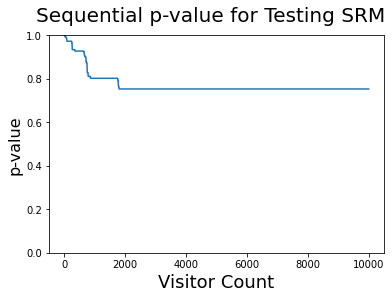

In [58]:
fig = plt.figure()
plt.plot(pvals)
fig.suptitle("Sequential p-value for Testing SRM", fontsize=20)
plt.xlabel("Visitor Count", fontsize=18)
plt.ylabel("p-value", fontsize=16)
plt.ylim(0, 1)
plt.show()

## Now we focus on timing the ssrm test. 
Note how random variable generation move from the main command tested (1st line) to the setup (larger block.)

In [81]:
timeits('ssrm_test.sequential_p_values(data, p_0)',
'''
from scipy.stats import multinomial
from ssrm_test import ssrm_test
import numpy as np
np.random.seed(0)
p_0 = [0.1, 0.5, 0.4]
p = [0.1, 0.49, 0.41]
n = {n}
data = multinomial.rvs(1, p, size={n})
''',
[10**i for i in range(7)],
5)

,n,times,speed
0,1,0.000429,2329.300693
1,10,0.001373,7284.140330
2,100,0.008012,12480.871816
3,1000,0.055967,17867.553004
4,10000,0.490591,20383.585570
5,100000,5.171656,19336.165084
6,1000000,51.079933,19577.159505


### --> Notice how speeds are around 600x slower.
In this case, we didn't have the patience to check data sizes as large.  

#### ---> Good news, though: performance doesn't slow much from linear (at least not yet at these data sizes.)

## Bayesian Analysis
One can obtain posterior probabilities (of an SRM) in the following way

In [70]:
data.shape

(10000, 3)

In [62]:
p_0

[0.1, 0.5, 0.4]

In [63]:
posterior_probabilities = ssrm_test.sequential_posterior_probabilities(data, p_0)

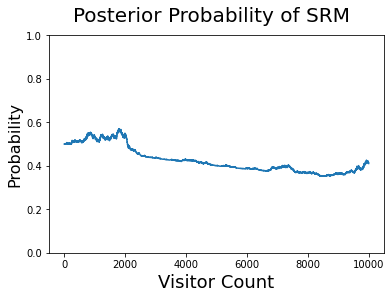

In [64]:
fig = plt.figure()
plt.plot(posterior_probabilities)
fig.suptitle("Posterior Probability of SRM", fontsize=20)
plt.xlabel("Visitor Count", fontsize=18)
plt.ylabel("Probability", fontsize=16)
plt.ylim(0, 1)
plt.show()

In [82]:
#old calc
timeits('ssrm_test.sequential_posterior_probabilities(data, p_0)',
'''
from scipy.stats import multinomial
from ssrm_test import ssrm_test
import numpy as np
np.random.seed(0)
p_0 = [0.1, 0.5, 0.4]
p = [0.1, 0.49, 0.41]
n = {n}
data = multinomial.rvs(1, p, size={n})
''',
[10**i for i in range(6)],
5)

,n,times,speed
0,1,0.000339,2950.000440
1,10,0.001098,9111.482816
2,100,0.006996,14294.771045
3,1000,0.051916,19261.767415
4,10000,0.528334,18927.438380
5,100000,5.095597,19624.786052


In [83]:
timeits('ssrm_test.sequential_posterior_probabilities(data, p_0)',
'''
from scipy.stats import multinomial
from ssrm_test import ssrm_test
import numpy as np
np.random.seed(0)
p_0 = [0.1, 0.5, 0.4]
p = [0.1, 0.49, 0.41]
n = {n}
data = multinomial.rvs(1, p, size={n})
''',
[10**i for i in range(7)],
5)

,n,times,speed
0,1,0.000482,2074.206824
1,10,0.001163,8597.998354
2,100,0.009254,10806.168715
3,1000,0.059261,16874.523048
4,10000,0.523576,19099.409844
5,100000,5.301129,18863.905817
6,1000000,51.650088,19361.051074


### --> Performance is similar to frequentist, and again we don't yet see systematic slowing below linear.  

(Interesting variability: slower at 10^5 than either 10^4, 10^6 in this run, and similarly in prior run for 10^4.)  
  
  
## --> END OF TIMINGS

## --> Key observations
- A basic setup like this is enough for very **basic** bechmarks  
- This is enough to confirm near-linear performance (at least up to data size 1m) 
- Caution: these numbers are not fully precise and informative:  
    1) Different calculations in the same notebook may affect each other  
    2) Realistic performance would be on a machine of known configuration not running 100's of browser tabs  
    2) This tests only for one repo version. In real life, it would be useful to see how performance has varied over multiple commits.  
    4) Our data frame might not be the prettiest way to present results.
- More advanced testing frameworks (like ASV) include tools to address each of these points:  
    1) Run each test in its own virtualenv  
    2) Really you'd need a dedicated, unburdened test machine, but at the very least capture the machine configuration  
    3) Test over commit history and include infrastructure to locate regressions  
    4) Basic json data and webserver visualization (if you can get it to run on your browser!)

## The Advantages of a Sequential Test
Consider the following tweet in which the user identifies an SRM using a non sequential frequentist test.

<img src="./images/kohavi.png" width=500></img>

We don't have access to this exact dataset, but we can create one just like it. In total there were 1637070 visitors in the experiment and the empirical sample ratio was 50.2%. With this information we can create a similar dataset as follows.

In [11]:
# Set the seed of our random number generator for reproducibility. Don't worry about this
np.random.seed(1)

# Our intended allocation probabilities
p_0 = [0.5, 0.5]

# The actual allocation probabilities
p = [0.502, 0.498]

# Specify number of visitors
n = 1637070

# Generate allocations
data = multinomial.rvs(1, p, size=n)

x = np.sum(data, axis=0)[0]
print(
    "Empirical sample ratios are {}% and {}%".format(
        round(100 * x / n, 1), round(100 * (n - x) / n, 1)
    )
)

Empirical sample ratios are 50.2% and 49.8%


The null hypothesis is that $p=0.5$. Let's compute the p-value from a two sided likelihood ratio test.

In [12]:
from scipy.stats import binom

print("{} visitors assigned to the control".format(x))
print(f"{x} visitors assigned to the control")
print("The non sequential p-value is {}".format(2 * binom.sf(x, n, 0.5)))

821935 visitors assigned to the control
821935 visitors assigned to the control
The non sequential p-value is 1.0639610058940994e-07


The user has been able to identify an SRM at the 0.05-alpha level test by using a standard likelihood ratio test at the end of the experiment. Note that this happened at the **end of the experiment**. Unfortunately, this dataset is now invalid for testing and this large experiment of $1637070$ visitors has gone to waste. One needs to fix the underlying issue and start a new experiment, collecting new data.

Ideally, you wouldn't have to wait until the end of an experiment to test if there is an SRM. This is exactly the main benefit a *sequential* SRM test provides: it can test for an SRM while your experiment is running, after **every single visitor**, without inflating the false positive rate. Let's run the SSRM test on the same dataset.

Computing... (this may take some time)


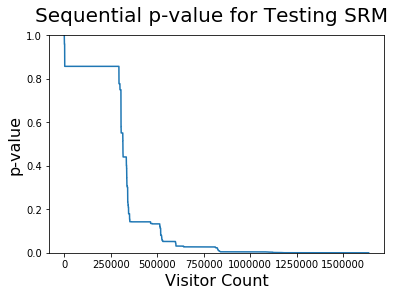

In [13]:
print("Computing... (this may take some time)")
pvals = ssrm_test.sequential_p_values(data, p_0)
fig = plt.figure()
plt.plot(pvals)
fig.suptitle("Sequential p-value for Testing SRM", fontsize=20)
plt.xlabel("Visitor Count", fontsize=16)
plt.ylabel("p-value", fontsize=16)
plt.ylim(0, 1)
plt.show()

In [15]:
pvals[:10]

[1,
 0.9999999999983533,
 0.9999999999983533,
 0.9999999999983533,
 0.9999999999983533,
 0.9998001498890131,
 0.9995004496110893,
 0.9991010488508143,
 0.9986020970713964,
 0.998003773453743]

In [14]:
sig_reached = len([p for p in pvals if p > 0.05])
print(
    "SSRM rejected the null (no SRM) at the alpha=0.05 level after {} visitors.".format(
        sig_reached
    )
)
print(
    "That is only {}% of the way through the experiment.".format(
        round(100 * sig_reached / n), 3
    )
)

SSRM rejected the null (no SRM) at the alpha=0.05 level after 598209 visitors.
That is only 37% of the way through the experiment.


As illustrated with the above example, SSRM allowed us to detect an SRM much sooner than the end of the experiment. Larger SRM's, and hence larger errors, are detected even sooner.

## Time Aggregated Data
Sometimes you may only have time aggregated data, instead of visitor-level data. That is, you might only know the total number of visitors assigned to each variation within an interval (or bucket) of time. For 3 variations, such time aggregated data can be represented as $[[100,120,99], [123,112,111], \dots$, where there is one inner array for each time bucket. The remaining steps are identical.

In [25]:
# Set the seed of our random number generator for reproducibility. Don't worry about this
np.random.seed(0)

# Our intended allocation probabilities
p_0 = [0.1, 0.5, 0.4]

# The actual allocation probabilities
p = [0.1, 0.49, 0.41]

# Generate allocations
data = multinomial.rvs(1000, p, size=100)

print("Now the data looks like: ")
print(data[1:10])

Now the data looks like: 
[[102 497 401]
 [122 483 395]
 [101 513 386]
 [118 483 399]
 [ 93 516 391]
 [109 497 394]
 [104 506 390]
 [ 90 528 382]
 [104 516 380]]


In [21]:
data.shape

(100, 3)

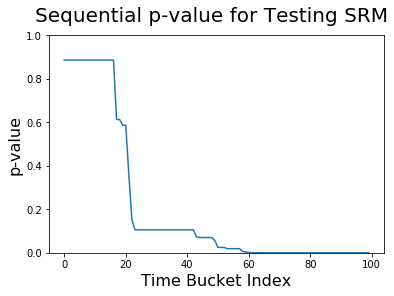

In [26]:
pvals = ssrm_test.sequential_p_values(data, p_0)
fig = plt.figure()
plt.plot(pvals)
fig.suptitle("Sequential p-value for Testing SRM", fontsize=20)
plt.xlabel("Time Bucket Index", fontsize=16)
plt.ylabel("p-value", fontsize=16)
plt.ylim(0, 1)
plt.show()

## Working With Pandas DataFrames
Suppose your data is inside a `pandas` DataFrame. The following cells will show you how to manipulate them into the format expected by the SSRM API. First, if you haven't done so already, install `pandas` by uncommenting out the code below, and let's create a sample DataFrame to work with.

In [27]:
# import sys
#!{sys.executable} -m pip install pandas

import pandas as pd

df = pd.DataFrame(data)
df.columns = ["variation_a", "variation_b", "variation_c"]
df.head()

,variation_a,variation_b,variation_c
0,84,489,427
1,102,497,401
2,122,483,395
3,101,513,386
4,118,483,399


The dataframe df gives us the total number of visitors assigned to each variation within an interval of time. It's very easy to extract these values using `df.values`. This gives an array of arrays, which can be fed into the ssrm api.

In [28]:
df.shape

(100, 3)

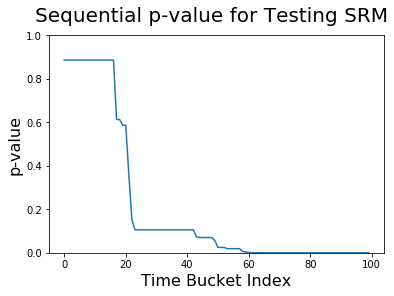

In [29]:
pvals = ssrm_test.sequential_p_values(df.values, p_0)
fig = plt.figure()
plt.plot(pvals)
fig.suptitle("Sequential p-value for Testing SRM", fontsize=20)
plt.xlabel("Time Bucket Index", fontsize=16)
plt.ylabel("p-value", fontsize=16)
plt.ylim(0, 1)
plt.show()

In [30]:
pvals

array([8.86423685e-01, 8.86423685e-01, 8.86423685e-01, 8.86423685e-01,
       8.86423685e-01, 8.86423685e-01, 8.86423685e-01, 8.86423685e-01,
       8.86423685e-01, 8.86423685e-01, 8.86423685e-01, 8.86423685e-01,
       8.86423685e-01, 8.86423685e-01, 8.86423685e-01, 8.86423685e-01,
       8.86423685e-01, 6.13072512e-01, 6.13072512e-01, 5.86553273e-01,
       5.86553273e-01, 3.58112646e-01, 1.51229614e-01, 1.05669868e-01,
       1.05669868e-01, 1.05669868e-01, 1.05669868e-01, 1.05669868e-01,
       1.05669868e-01, 1.05669868e-01, 1.05669868e-01, 1.05669868e-01,
       1.05669868e-01, 1.05669868e-01, 1.05669868e-01, 1.05669868e-01,
       1.05669868e-01, 1.05669868e-01, 1.05669868e-01, 1.05669868e-01,
       1.05669868e-01, 1.05669868e-01, 1.05669868e-01, 7.32132586e-02,
       7.01407825e-02, 7.01407825e-02, 7.01407825e-02, 7.01407825e-02,
       7.01407825e-02, 5.53655876e-02, 2.47381227e-02, 2.47381227e-02,
       2.45060694e-02, 1.90059985e-02, 1.90059985e-02, 1.90059985e-02,
      